In [1]:
import pandas as pd
from get_chain import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
chain = ret_chain("AAPL", "2025-06-18")

In [3]:
option_data = chain.values()  # Now we get the real options data

flattened_data = []
for opt in option_data:
    row = {
        "symbol": opt.symbol,  # Extract symbol
        "delta": getattr(opt.greeks, "delta", None),
        "gamma": getattr(opt.greeks, "gamma", None),
        "rho": getattr(opt.greeks, "rho", None),
        "theta": getattr(opt.greeks, "theta", None),
        "vega": getattr(opt.greeks, "vega", None),
        "implied_volatility": getattr(opt, "implied_volatility", None),
        "ask_price": getattr(opt.latest_quote, "ask_price", None),
        "ask_size": getattr(opt.latest_quote, "ask_size", None),
        "bid_price": getattr(opt.latest_quote, "bid_price", None),
        "bid_size": getattr(opt.latest_quote, "bid_size", None),
        "conditions": getattr(opt.latest_quote, "conditions", None),
        "tape": getattr(opt.latest_quote, "tape", None),
        "timestamp": getattr(opt.latest_quote, "timestamp", None)
    }
    flattened_data.append(row)

# Convert to DataFrame
df = pd.DataFrame(flattened_data)

In [4]:
df["underlying_symbol"] = df["symbol"].str.extract(r"^([A-Z]+)")
df["expiration"] = df["symbol"].str.extract(r"(\d{6})")
df["expiration"] = pd.to_datetime(df["expiration"], format="%y%m%d")
df["option_type"] = df["symbol"].str.extract(r"(\d{6})([PC])")[1]
df["strike_price"] = df["symbol"].str.extract(r"([PC])(\d{8})")[1].astype(float) / 1000  # Convert to proper decimal

# Reorder columns for clarity
df = df[["symbol", "underlying_symbol", "expiration", "option_type", "strike_price", "delta", "gamma", "rho", "theta", "vega", "implied_volatility", "ask_price", "ask_size", "bid_price", "bid_size", "conditions", "tape", "timestamp"]].sort_values(by="strike_price")

In [5]:
df.head()

,symbol,underlying_symbol,expiration,option_type,strike_price,delta,gamma,rho,theta,vega,implied_volatility,ask_price,ask_size,bid_price,bid_size,conditions,tape,timestamp
31,AAPL250620C00005000,AAPL,2025-06-20,C,5.0,NaN,NaN,NaN,NaN,NaN,NaN,237.80,100.0,235.65,27.0,,None,2025-02-28 20:59:59.988150+00:00
87,AAPL250620P00005000,AAPL,2025-06-20,P,5.0,NaN,NaN,NaN,NaN,NaN,NaN,0.02,10.0,0.00,0.0,,None,2025-02-28 21:00:01.720659+00:00
57,AAPL250620P00010000,AAPL,2025-06-20,P,10.0,NaN,NaN,NaN,NaN,NaN,NaN,0.02,10.0,0.00,0.0,,None,2025-02-28 21:00:01.720829+00:00
16,AAPL250620C00010000,AAPL,2025-06-20,C,10.0,NaN,NaN,NaN,NaN,NaN,NaN,233.45,100.0,230.65,27.0,,None,2025-02-28 20:59:59.996033+00:00
77,AAPL250620C00015000,AAPL,2025-06-20,C,15.0,NaN,NaN,NaN,NaN,NaN,NaN,228.55,100.0,225.35,27.0,,None,2025-02-28 20:59:59.995532+00:00


In [6]:
# Ensure the DataFrame is sorted by strike price within each option type
df = df.sort_values(["option_type", "strike_price"]).reset_index(drop=True)

# Function to find the closest available strikes within the same option type
def find_nearest_strikes(df_subset, middle_strike):
    lower_strikes = df_subset[df_subset["strike_price"] < middle_strike]["strike_price"]
    upper_strikes = df_subset[df_subset["strike_price"] > middle_strike]["strike_price"]

    if lower_strikes.empty or upper_strikes.empty:
        return None, None  # No valid butterfly spread

    lower_strike = lower_strikes.iloc[-1]  # Closest lower strike
    upper_strike = upper_strikes.iloc[0]  # Closest upper strike

    return lower_strike, upper_strike

# Initialize butterfly spread price column
df["butterfly_spread_price"] = np.nan

# Process Calls and Puts separately
for option_type in ["C", "P"]:
    df_subset = df[df["option_type"] == option_type]  # Filter by option type
    
    for idx, row in df_subset.iterrows():
        middle_strike = row["strike_price"]
        
        # Find the closest lower and upper strikes within the same option type
        lower_strike, upper_strike = find_nearest_strikes(df_subset, middle_strike)
        
        if lower_strike is None or upper_strike is None:
            continue  # Skip if a valid butterfly cannot be formed

        # Retrieve the corresponding bid/ask prices
        lower_option = df_subset[df_subset["strike_price"] == lower_strike].iloc[0]
        upper_option = df_subset[df_subset["strike_price"] == upper_strike].iloc[0]

        # Butterfly Spread Price Calculation
        w1 = (upper_strike - middle_strike) / (upper_strike - lower_strike)
        w2 = -1
        w3 = 1 - w1

        butterfly_price = (w1*lower_option["ask_price"] + w3*upper_option["ask_price"]) + w2 * row["bid_price"]
        
        # Store the result
        df.at[idx, "butterfly_spread_price"] = butterfly_price

# Drop rows with NaN values (invalid butterfly spreads)
df = df.dropna(subset=["butterfly_spread_price"])


In [7]:
calls = df.loc[df['option_type'] == 'C']
puts = df.loc[df['option_type'] == 'P']

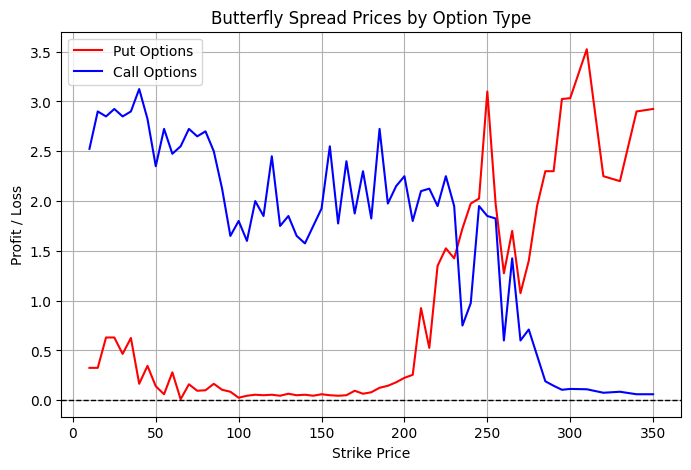

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(puts['strike_price'], puts['butterfly_spread_price'], label="Put Options", color='r')
plt.plot(calls['strike_price'], calls['butterfly_spread_price'], label="Call Options", color ='b')
plt.axhline(0, color="black", linestyle="--", linewidth=1) 

plt.xlabel("Strike Price")
plt.ylabel("Profit / Loss")
plt.title(f"Butterfly Spread Prices by Option Type")
plt.legend()
plt.grid()
plt.show()


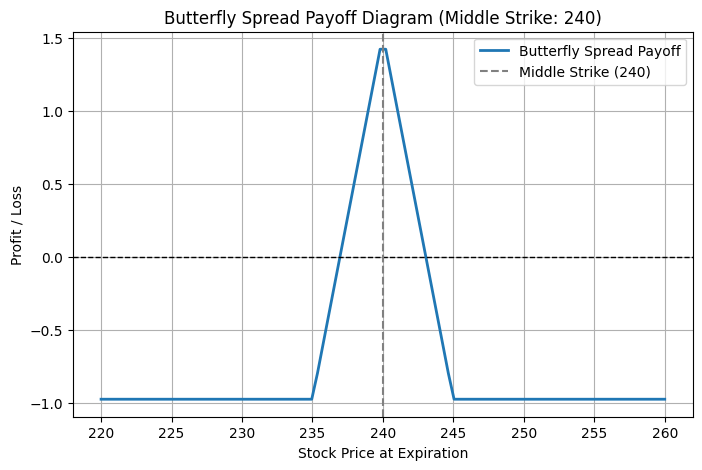

In [9]:
# Define a function to calculate butterfly spread payoff
def butterfly_spread_payoff(strike_prices, premium_prices, stock_prices):
    K1, K2, K3 = strike_prices
    P1, P2, P3 = premium_prices  # Premiums paid/received for each leg

    w1 = (K3 - K2) / (K3 - K1)
    w2 = -1
    w3 = 1 - w1

    # Calculate individual option payoffs
    lower_leg = w1 * (np.maximum(stock_prices - K1, 0) - P1)  # Long Call/Put
    middle_leg = w2 * (np.maximum(stock_prices - K2, 0) - P2)  # Short 2 Calls/Puts
    upper_leg = w3 * (np.maximum(stock_prices - K3, 0) - P3)  # Long Call/Put

    # Total Butterfly Payoff
    total_payoff = lower_leg + middle_leg + upper_leg
    
    return total_payoff

# Select a single middle strike price
middle_strike = 240

# Find the closest available lower and upper strikes
lower_strike, upper_strike = find_nearest_strikes(df.loc[df['option_type'] == 'C'], middle_strike)

# Get bid/ask prices for premiums
lower_option = df[df["strike_price"] == lower_strike].iloc[0]
middle_option = df[df["strike_price"] == middle_strike].iloc[0]
upper_option = df[df["strike_price"] == upper_strike].iloc[0]

# Use bid/ask prices as premiums
premium_lower = (lower_option["ask_price"])
premium_middle = (middle_option["bid_price"])
premium_upper = (upper_option["ask_price"])

# Define stock price range for visualization
stock_prices = np.linspace(middle_strike - 20, middle_strike + 20, 100)

# Calculate butterfly spread payoff
payoff = butterfly_spread_payoff(
    strike_prices=[lower_strike, middle_strike, upper_strike],
    premium_prices=[premium_lower, premium_middle, premium_upper],
    stock_prices=stock_prices
)

# Plot the payoff diagram
plt.figure(figsize=(8, 5))
plt.plot(stock_prices, payoff, label="Butterfly Spread Payoff", linewidth=2)
plt.axhline(0, color="black", linestyle="--", linewidth=1)  # Breakeven line
plt.axvline(middle_strike, color="gray", linestyle="--", label=f"Middle Strike ({middle_strike})")

plt.xlabel("Stock Price at Expiration")
plt.ylabel("Profit / Loss")
plt.title(f"Butterfly Spread Payoff Diagram (Middle Strike: {middle_strike})")
plt.legend()
plt.grid()
plt.show()
